<b>Data Sources</b>
* Data on parcels from [San Bernardino Open Data Portal](https://open.sbcounty.gov/datasets/countywide-parcels/about) and [Riverside County GIS](https://gis.rivco.org/pages/data-distribution)
* Shapefiles for National Highway Freight Network from [Federal Highway Administration ](https://fpcb.ops.fhwa.dot.gov/tools_nhfn.aspx)
* Data on warehouse locations and year built from [Warehouse CITY](https://radicalresearch.shinyapps.io/WarehouseCITY)

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

<b>Part 1: Merge Assessor Parcels Together and Clip to Within 70 Miles of Ontario Airport</b>

Import Riverside data and clean it up so that it matches San Bernardino data

In [2]:
# import data for all parcels in Riverside County
riverside = gpd.read_file('data/riversidegeom/Udsparcels.shp')
# set APN to be the index
riverside.APN=riverside.APN.astype('float')
riverside.set_index('APN',inplace=True)
# drop unneccessary columns
riverside=riverside[['LAND','geometry']]
# rename columns to match san bernardino parcels
riverside.rename(columns={'LAND':'LAND_VALUE'},inplace=True)
# check if APN is unique
print(riverside.index.is_unique)
riverside.head()

False


,LAND_VALUE,geometry
APN,,
727271026.0,0.0,"POLYGON ((6614112.612 2150594.430, 6614159.734..."
779201018.0,0.0,"POLYGON ((6570999.526 2188909.899, 6570971.279..."
182084014.0,0.0,"POLYGON ((6204064.073 2310041.573, 6204067.037..."
290080018.0,0.0,"POLYGON ((6196599.470 2223714.710, 6196589.146..."
300090005.0,0.0,"POLYGON ((6272976.191 2246330.019, 6272976.353..."


In [3]:
#drop na
riverside = riverside.dropna()
# dissolve parcel subdivisions
riverside = riverside.dissolve(by='APN',aggfunc={"LAND_VALUE": 'sum'})
print(riverside.index.is_unique)
riverside.head()

True


,geometry,LAND_VALUE
APN,,
101020001.0,"POLYGON ((6135980.318 2280787.576, 6135294.768...",0.0
101020003.0,"POLYGON ((6144418.489 2282740.357, 6144418.117...",913089.0
101020004.0,"POLYGON ((6142427.438 2282804.547, 6142340.578...",0.0
101020005.0,"POLYGON ((6135980.318 2280787.576, 6136129.368...",249728.0
101030001.0,"POLYGON ((6145501.841 2282705.432, 6145501.742...",243074.0


<Axes: >

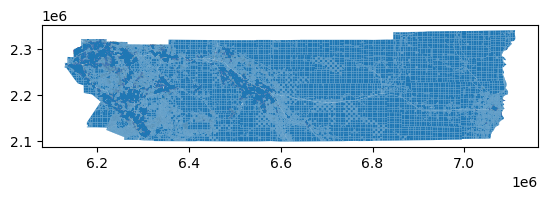

In [4]:
riverside.plot()

Import San Bernardino data and clean it up so that it matches Riverside data

In [5]:
# import data for all parcels in San Bernadino County downloaded from https://open.sbcounty.gov/datasets/countywide-parcels/about.
sanbernardino = gpd.read_file('data/countywide_parcels/pbmpoly.shp')
# keep just columns we need to reduce file size
sanbernardino=sanbernardino[['APN','LAND_VALUE', 'geometry']]
# drop APNs that are missing
sanbernardino.APN=sanbernardino.APN.astype('float')
sanbernardino=sanbernardino.dropna()
sanbernardino=sanbernardino[sanbernardino.APN !=0]
# set APN to be the index.
sanbernardino.set_index('APN',inplace=True)
# check that it is unique
print(sanbernardino.index.is_unique)
sanbernardino.head()

False


,LAND_VALUE,geometry
APN,,
10862210.0,98997.0,"POLYGON ((6678515.643 1856069.192, 6678515.578..."
10862209.0,153482.0,"POLYGON ((6678664.305 1856069.147, 6678663.866..."
10862238.0,10874.0,"POLYGON ((6678802.917 1856069.106, 6678802.850..."
10862258.0,88379.0,"POLYGON ((6679095.061 1856069.018, 6679094.925..."
10862257.0,100311.0,"POLYGON ((6679238.781 1856068.975, 6679238.235..."


In [6]:
# dissolve parcel subdivisions
sanbernardino = sanbernardino.dissolve(by='APN',aggfunc={"LAND_VALUE": 'sum'})
print(sanbernardino.index.is_unique)
sanbernardino.head()

True


,geometry,LAND_VALUE
APN,,
10829107.0,"POLYGON ((6675457.139 1853449.721, 6676118.522...",0.0
10829113.0,"POLYGON ((6676118.522 1853450.723, 6676250.489...",0.0
10829114.0,"POLYGON ((6676250.489 1853450.923, 6676382.774...",0.0
10830101.0,"POLYGON ((6674319.167 1852831.711, 6674435.145...",152000.0
10830102.0,"POLYGON ((6674319.359 1852779.717, 6674435.360...",84510.0


<Axes: >

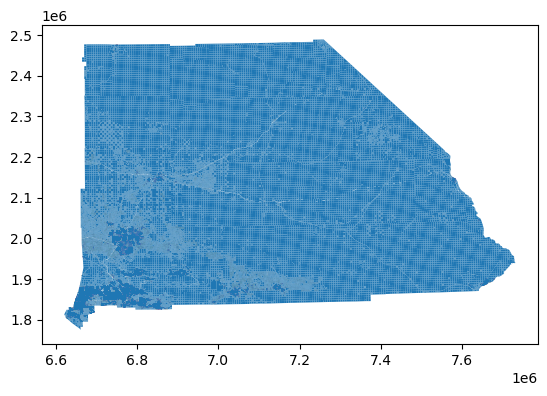

In [7]:
sanbernardino.plot()

Concatenate the two datasets!

In [8]:
# riverside and san bernardino have different projections, but we're going to go with san bernardino (2229) because it's the same as LA County
riverside=riverside.to_crs(2229)
# concatenate
parcels = pd.concat([riverside, sanbernardino])
print(parcels.index.is_unique)
parcels.sample(5)

True


,geometry,LAND_VALUE
APN,,
961342012.0,"POLYGON ((6834842.693 1628912.707, 6834809.311...",94684.0
33409125.0,"POLYGON ((6791878.072 1912131.784, 6791881.569...",36211.0
146270073.0,"POLYGON ((6716148.404 1792706.280, 6716148.504...",0.0
218021008.0,"POLYGON ((6742991.322 1811838.061, 6742993.421...",69588.0
678121017.0,"POLYGON ((7029263.506 1763210.530, 7029262.638...",78030.0


In [9]:
print(len(riverside)+len(sanbernardino)==len(parcels))

True


In [10]:
# calculate a 70 mile buffer around the Ontaria Airport & turn this into a geodataframe
airport=gpd.points_from_xy(x=[6683335.118285051], y=[1843271.4373799062], crs=2229)
buffer=airport.buffer(369600)
parcels = parcels.to_crs(2229)
buffer=gpd.GeoDataFrame(geometry=buffer,crs=2229)
# clip the parcels to this buffer
parcels_clipped=gpd.clip(parcels, buffer, keep_geom_type=True)

In [11]:
print(len(parcels))
print(len(parcels_clipped))
print(parcels_clipped.index.is_unique)

1653586
1410968
True


<Axes: >

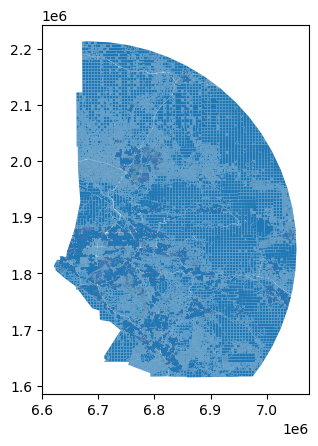

In [12]:
parcels_clipped.plot()

<b>Part 2: Calculate Distance to Freight</b><br>
Here we use shapefiles of the locations of the National Highway Freight Network to calculate the distance from each parcel to the network.

In [13]:
freight = gpd.read_file('data/NHFN_GIS_Shapefiles_Jan_2022/PublicRelease/National-NHFN-2022.shp')
# Keep just columns we need to reduce file size.
freight=freight[['geometry']]
# join info about nearest freight route to each parcel 
parcels_clipped = gpd.sjoin_nearest(parcels_clipped, freight.to_crs(2229), how='left',rsuffix='freight',distance_col="distances",max_distance=400000)

In [14]:
# drop columns created in the spatial join
parcels_clipped = parcels_clipped.drop(columns=['index_freight'])
# drop duplicates created in the spatial join
parcels_clipped.reset_index(inplace=True)
parcels_clipped.drop_duplicates(subset=['APN'],keep='first', inplace=True)
parcels_clipped.set_index('APN',inplace=True)
print(parcels_clipped.index.is_unique)
parcels_clipped.head()

True


,geometry,LAND_VALUE,distances
APN,,,
933260003.0,"POLYGON ((6783290.923 1627339.246, 6783270.638...",48418.0,38449.033944
933190003.0,"POLYGON ((6782457.132 1627327.826, 6781572.340...",210496.0,39355.337470
933200001.0,"POLYGON ((6783360.412 1628192.011, 6783279.449...",347975.0,39133.409768
933180027.0,"POLYGON ((6782203.810 1629150.378, 6781644.461...",88468.0,39830.303362
933180028.0,"POLYGON ((6782031.887 1630184.586, 6783026.297...",334555.0,38830.371787


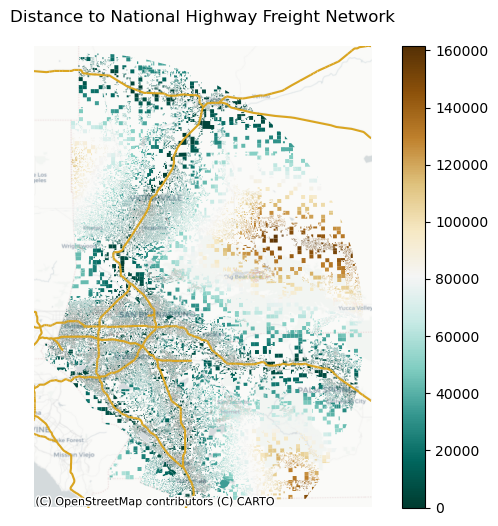

In [15]:
# plot 10% of parcels (to reduce drawing time) to make sure results seem reasonable
minx, miny, maxx, maxy = parcels_clipped.geometry.total_bounds
fig, ax = plt.subplots(figsize=(8, 6))
parcels_clipped.sample(frac=0.25).plot(ax=ax,column='distances',legend=True,cmap='BrBG_r')
freight.to_crs(2229).plot(ax=ax,color='#daa520')
ax.axis('off')
ax.set_xlim(minx-10000,maxx+10000)
ax.set_ylim(miny-10000,maxy+10000)
ax.set_title('Distance to National Highway Freight Network')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=2229)

<b>Part 3: Determine Presence of Warehouses</b>

In [16]:
# import warehouse data downloaded from Warehouse City (https://radicalresearch.shinyapps.io/WarehouseCITY/)
warehouses = pd.read_csv('data/Warehouse_List.csv')

# rename columnn names so that they don't have spaces and are easier to work with
warehouses.rename(columns={'Assessor parcel number':'APN','Building classification':'building_class','Year built':'year',
                           'Acres':'acres','Building sq.ft.':'sqft'},inplace=True)
warehouses.head()

,Category,APN,building_class,year,acres,sqft
0,Planned and Approved,World Logistics Center,TBD,2025,2650,63499000
1,Planned and Approved,Legacy Highlands Phase II Specific Plan,TBD,2025,1386,33207000
2,Planned and Approved,Airport Gateway Specific Plan Area,TBD,2025,613,14689000
3,Planned and Approved,Stoneridge Commerce Center,TBD,2025,606,14523000
4,Planned and Approved,Speedway Commerce Center,TBD,2025,464,11118000


Between the simple maps above and some additional research in the [County Zoning District Maps](https://sbcounty.maps.arcgis.com/apps/MapSeries/index.html?appid=f5a50c44766b4c36a3ae014497aa430d) we have confirmed that the duplicated Assessor Numbers are associated with parcels with multiple subdivisions with warehouses on them. We want our analysis to take place at the parcel level, so we will aggregate our data accordingly.

In [17]:
# get category and buiding class associated with each parcel.
warehouse_parcels=warehouses.groupby('APN')[['building_class']].first()
# get first year that a warehouse was built on the parcel.
year=warehouses.groupby('APN')[['year']].min()
# get total acres of warehouses built on the parcel.
area=warehouses.groupby('APN')[['acres','sqft']].sum()
# get number of warehouses
num_warehouses=warehouses.groupby('APN').size()
num_warehouses.name='num_warehouses'
# join all of these column together on parcel_id.
warehouse_parcels=warehouse_parcels.join(year).join(area).join(num_warehouses)
warehouse_parcels.sample(5)

,building_class,year,acres,sqft,num_warehouses
APN,,,,,
8125-016-007,"Warehousing, Distribution, Storage",1980,2,40000,1
160510005,warehouse/dry storage,2001,26,625000,1
7306-025-021,"Warehousing, Distribution, Storage",1989,11,254000,1
115050034,light industrial,2004,7,157000,1
8437-019-014,"Warehousing, Distribution, Storage",2017,2,39000,1


In [18]:
# use lambda functions to denote whether warehouse had been built on each parcel by 2010 and by 2020.
warehouse_parcels['warehouse_2010']=warehouse_parcels.year.apply(lambda x: True if x<=2010 else False)
warehouse_parcels['warehouse_2020']=warehouse_parcels.year.apply(lambda x: True if x<=2020 else False)
warehouse_parcels['built_2010s']=warehouse_parcels.year.apply(lambda x: True if (2010 <= x <= 2020) else False)
# check to see that this has worked.
warehouse_parcels.head()

,building_class,year,acres,sqft,num_warehouses,warehouse_2010,warehouse_2020,built_2010s
APN,,,,,,,,
011011113,storage warehouse,2021,2,41000,1,False,False,False
011011114,storage warehouse,2021,2,39000,1,False,False,False
011012110,distribution warehouse,1982,4,106000,1,True,True,False
011031145,distribution warehouse,2016,8,187000,1,False,True,True
011031146,distribution warehouse,2016,25,589000,1,False,True,True


In [19]:
#Need to do some manipulations of indexes for the join. First, pull the APN column out of the indices so we can edit them. 
warehouse_parcels = warehouse_parcels.reset_index()
#Now, remove the dashes and any non-numeric columns so we can have better matches. 
warehouse_parcels['APN'] = warehouse_parcels['APN'].apply(lambda x: x.replace("-",""))
warehouse_parcels = warehouse_parcels[warehouse_parcels.APN.apply(lambda x: x.isnumeric())]
#Change the APN column to float in both the warehouses and parcels dfs so we can join them (stirng and int gave me trouble)
warehouse_parcels['APN'] = warehouse_parcels['APN'].astype('float')
warehouse_parcels.head()

,APN,building_class,year,acres,sqft,num_warehouses,warehouse_2010,warehouse_2020,built_2010s
0,11011113.0,storage warehouse,2021,2,41000,1,False,False,False
1,11011114.0,storage warehouse,2021,2,39000,1,False,False,False
2,11012110.0,distribution warehouse,1982,4,106000,1,True,True,False
3,11031145.0,distribution warehouse,2016,8,187000,1,False,True,True
4,11031146.0,distribution warehouse,2016,25,589000,1,False,True,True


In [20]:
# join warehouse data onto the parcels
parcels_warehouses=parcels_clipped.join(warehouse_parcels.set_index('APN'), how = 'left', on = 'APN')
print(parcels_warehouses.index.is_unique)
parcels_warehouses.head(5)

True


,geometry,LAND_VALUE,distances,building_class,year,acres,sqft,num_warehouses,warehouse_2010,warehouse_2020,built_2010s
APN,,,,,,,,,,,
933260003.0,"POLYGON ((6783290.923 1627339.246, 6783270.638...",48418.0,38449.033944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
933190003.0,"POLYGON ((6782457.132 1627327.826, 6781572.340...",210496.0,39355.337470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
933200001.0,"POLYGON ((6783360.412 1628192.011, 6783279.449...",347975.0,39133.409768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
933180027.0,"POLYGON ((6782203.810 1629150.378, 6781644.461...",88468.0,39830.303362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
933180028.0,"POLYGON ((6782031.887 1630184.586, 6783026.297...",334555.0,38830.371787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Clean up warehouse data for pacels without warehouses
parcels_warehouses.num_warehouses.fillna(0,inplace=True)
parcels_warehouses.warehouse_2010.fillna(0,inplace=True)
parcels_warehouses.warehouse_2020.fillna(0,inplace=True)
parcels_warehouses.built_2010s.fillna(0,inplace=True)
parcels_warehouses.head()

,geometry,LAND_VALUE,distances,building_class,year,acres,sqft,num_warehouses,warehouse_2010,warehouse_2020,built_2010s
APN,,,,,,,,,,,
933260003.0,"POLYGON ((6783290.923 1627339.246, 6783270.638...",48418.0,38449.033944,NaN,NaN,NaN,NaN,0.0,0,0,0
933190003.0,"POLYGON ((6782457.132 1627327.826, 6781572.340...",210496.0,39355.337470,NaN,NaN,NaN,NaN,0.0,0,0,0
933200001.0,"POLYGON ((6783360.412 1628192.011, 6783279.449...",347975.0,39133.409768,NaN,NaN,NaN,NaN,0.0,0,0,0
933180027.0,"POLYGON ((6782203.810 1629150.378, 6781644.461...",88468.0,39830.303362,NaN,NaN,NaN,NaN,0.0,0,0,0
933180028.0,"POLYGON ((6782031.887 1630184.586, 6783026.297...",334555.0,38830.371787,NaN,NaN,NaN,NaN,0.0,0,0,0


Map to ensure that this looks like Warehouse City (map below is screenshot)

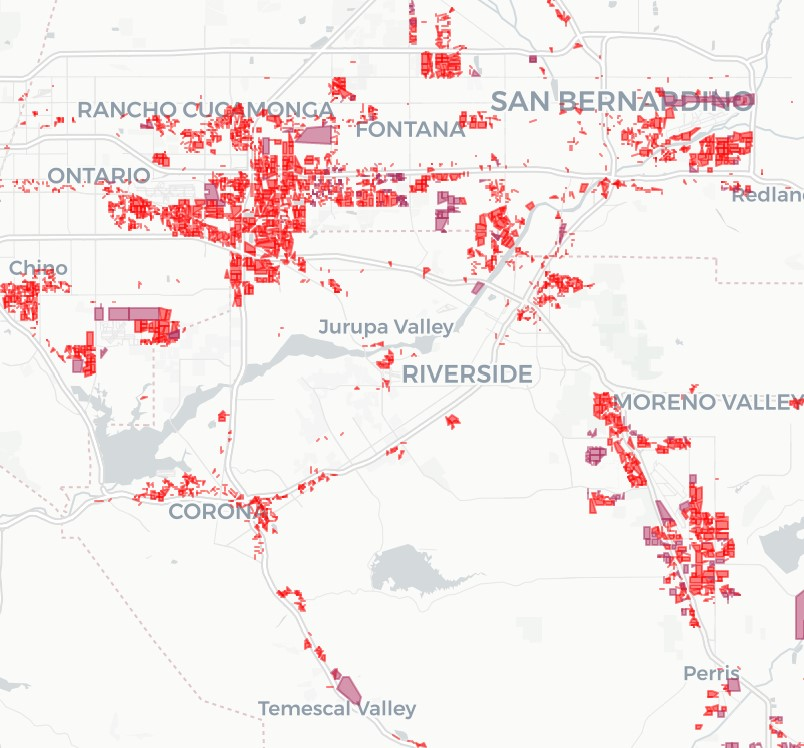

In [22]:
counties=gpd.read_file('data/CA_Counties/CA_Counties_TIGER2016.shp')
counties=counties[counties.NAME.apply(lambda x: True if x in ('Riverside','San Bernardino') else False)]

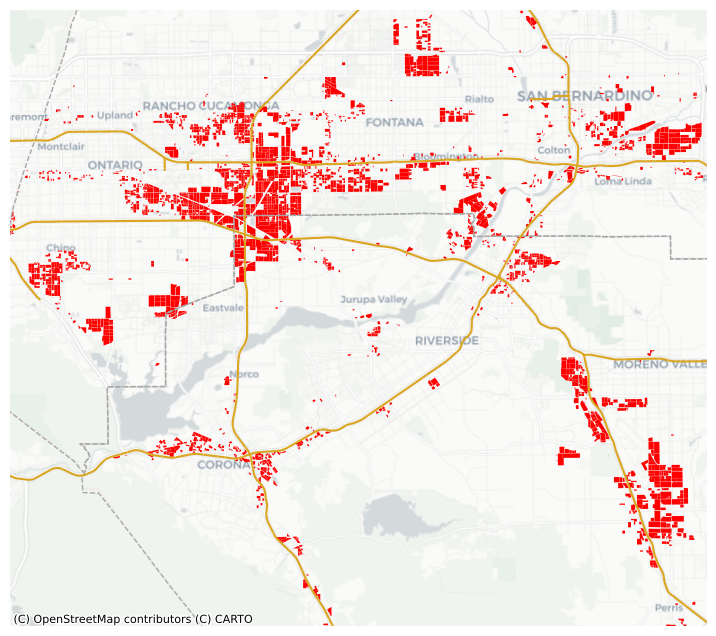

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))
parcels_warehouses[parcels_warehouses['num_warehouses']>0].plot(ax=ax,color='red')
freight.to_crs(2229).plot(ax=ax,color='#daa520')
counties.plot(ax=ax,color='none')
counties.to_crs(2229).plot(ax=ax,color='none',edgecolor='darkgrey',linestyle='dashed')
ax.axis('off')
ax.set_xlim(6643710, 6804764)
ax.set_ylim(1740000,1882403)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=2229)

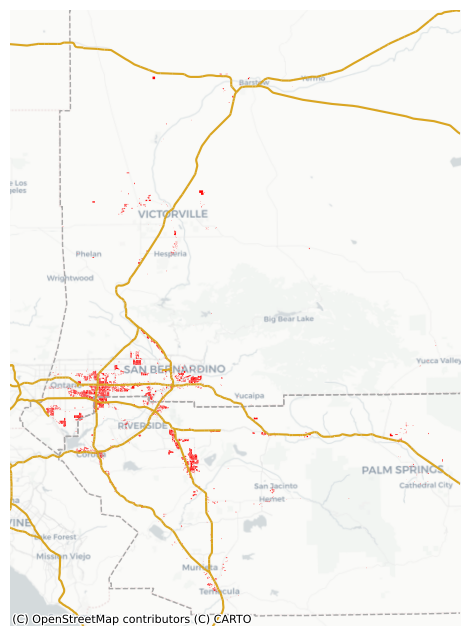

In [24]:
minx, miny, maxx, maxy = parcels_warehouses.geometry.total_bounds
fig, ax = plt.subplots(figsize=(10, 8))
parcels_warehouses[parcels_warehouses['num_warehouses']>0].plot(ax=ax,color='red')
freight.to_crs(2229).plot(ax=ax,color='#daa520')
counties.plot(ax=ax,color='none')
counties.to_crs(2229).plot(ax=ax,color='none',edgecolor='darkgrey',linestyle='dashed')
ax.axis('off')
ax.set_xlim(minx-10000,maxx+10000)
ax.set_ylim(miny-10000,maxy+10000)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=2229)

One final map to make sure that all of this data wrangling didn't drop all of our pacels

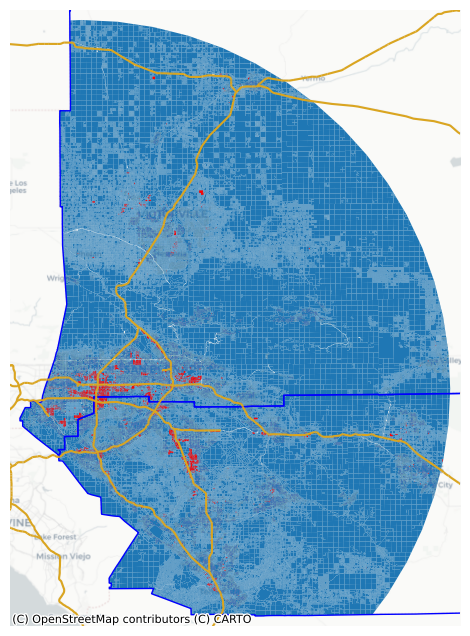

In [25]:
minx, miny, maxx, maxy = parcels_clipped.geometry.total_bounds
fig, ax = plt.subplots(figsize=(10, 8))
parcels_clipped.plot(ax=ax)
parcels_warehouses[parcels_warehouses['num_warehouses']>0].plot(ax=ax,color='red')
freight.to_crs(2229).plot(ax=ax,color='#daa520')
counties.plot(ax=ax,color='none')
counties.to_crs(2229).plot(ax=ax,color='none',edgecolor='blue')
ax.axis('off')
ax.set_xlim(minx-10000,maxx+10000)
ax.set_ylim(miny-10000,maxy+10000)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=2229)

Since there are obvious spatial patterns, we'll finally ad in the latitude and longitude of the centroid of each parcel

In [26]:
# first calculate the centroid of each parcel and then extract latitude and longitude
parcels_warehouses['parcel_centroid']=parcels_warehouses.centroid
parcels_warehouses['lon'] = parcels_warehouses.parcel_centroid.to_crs(4326).x
parcels_warehouses['lat'] = parcels_warehouses.parcel_centroid.to_crs(4326).y
parcels_warehouses=parcels_warehouses.drop(columns=['parcel_centroid'])
print(parcels_warehouses.index.is_unique)
parcels_warehouses.head()

True


,geometry,LAND_VALUE,distances,building_class,year,acres,sqft,num_warehouses,warehouse_2010,warehouse_2020,built_2010s,lon,lat
APN,,,,,,,,,,,,,
933260003.0,"POLYGON ((6783290.923 1627339.246, 6783270.638...",48418.0,38449.033944,NaN,NaN,NaN,NaN,0.0,0,0,0,-117.275300,33.461170
933190003.0,"POLYGON ((6782457.132 1627327.826, 6781572.340...",210496.0,39355.337470,NaN,NaN,NaN,NaN,0.0,0,0,0,-117.276927,33.464093
933200001.0,"POLYGON ((6783360.412 1628192.011, 6783279.449...",347975.0,39133.409768,NaN,NaN,NaN,NaN,0.0,0,0,0,-117.275362,33.465158
933180027.0,"POLYGON ((6782203.810 1629150.378, 6781644.461...",88468.0,39830.303362,NaN,NaN,NaN,NaN,0.0,0,0,0,-117.277299,33.468321
933180028.0,"POLYGON ((6782031.887 1630184.586, 6783026.297...",334555.0,38830.371787,NaN,NaN,NaN,NaN,0.0,0,0,0,-117.275263,33.469289


In [27]:
# saving new file
parcels_warehouses.to_file("data/parcels_warehouses.gpkg", driver='GPKG')